In [1]:
import sys
sys.path.append("..")
sys.path.append("../src")
import pandas as pd
from pred.utils import build_dataset_from_df
import matplotlib.pyplot as plt

/home/beomyeol/anaconda3/envs/k8s-ray/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pathlib import Path
from gluonts.model.predictor import Predictor

# device = "cuda"
device = "cpu"
model_path = Path("/home/beomyeol/Workspace/ibm/faro/results/pred/top9_twitter_1_2400_avgproc_min_int5m_reduced_6hr/gluonts/clen=15_plen=5/deepar/bs=32_lr=0.0001/LSTM/l=2_lw=512_do=0.1")
predictor = Predictor.deserialize(model_path, device=device)

/home/beomyeol/anaconda3/envs/k8s-ray/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [18]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from gluonts.dataset.pandas import PandasDataset

df = pd.read_pickle(
    "/home/beomyeol/Workspace/ibm/faro/experiments/top9_twitter_1_2400_avgproc_min_int5m_reduced_6hr/top9_twitter_1_2400_avgproc_min_int5m_reduced_6hr.pkl")
val = build_dataset_from_df(df[df.day == 11])
start = '2023-01-01'
# freq = 'min'  # https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
freq = pd.offsets.Minute()

target = val[val.group == "twitter"].value.reset_index(drop=True)[:50]

target = to_pandas(
    {'target': target.to_numpy(),
      'start': start},
    freq=freq)
data = PandasDataset(target)

<AxesSubplot:>

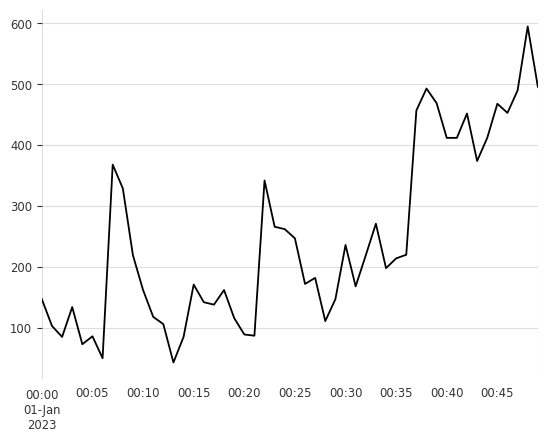

In [19]:
target.plot()

In [20]:
context_len = predictor.network.model.context_length
print(context_len)
pred_len = predictor.prediction_length
print(pred_len)

15
5


In [22]:
import time
import numpy as np

base = 10
begin = pd.Timestamp(start) + base * pd.offsets.Minute()
end = begin + (context_len - 1) * pd.offsets.Minute()
series = target[begin:end]

tss = []
for _ in range(20):
    t = time.perf_counter()
    preds = predictor.predict(ListDataset(
        [{"start": begin, "target": series}], freq=freq
    ))
    preds = list(preds)
    tss.append(time.perf_counter() - t)

print(np.mean(tss))

0.020742476207669825


In [23]:
# print(target.values[:10])
# print(series)
print(begin)
print(end)
print(preds[0].samples.shape)

2023-01-01 00:10:00
2023-01-01 00:24:00
(100, 5)


In [24]:
import pytorch_lightning as pl
pl.seed_everything(42)
predictor = Predictor.deserialize(model_path, device=device)
input_dataset = ListDataset(
    [{"start": pd.Period.now(freq=freq) - context_len, "target": series}], freq=freq)
print(input_dataset)

preds = predictor.predict(input_dataset, num_samples=None)
preds = list(preds)
pred = preds[0]
# print(pred)
print(pred.mean)
# print(pred.median)
# print(pred.quantile(0.8))

Global seed set to 42


[{'start': Period('2023-04-17 18:40', 'T'), 'target': array([162., 118., 106.,  43.,  85., 171., 142., 138., 162., 116.,  89.,
        87., 342., 266., 262.], dtype=float32)}]
[167.76851 172.00043 164.71667 162.6153  163.70535]


/home/beomyeol/anaconda3/envs/k8s-ray/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [25]:
import importlib
import gluonts_predictor
importlib.reload(gluonts_predictor)
pl.seed_everything(42)

predictor_x = gluonts_predictor.GluonTSPredictor(
    model_path=model_path, 
    window_size_s=5 * 60,
    head_name="head",
    deployment_name="dep",
    unit_time_s=60
)
# list(predictor_x.model.predict(input_dataset))[0].mean
input_metrics = (series.values.astype(int), int(series.sum()))
print(input_metrics)
predictor_x.predict(
    input_metrics=input_metrics,
    current_ts=5 * 60,
)

Global seed set to 42
/home/beomyeol/anaconda3/envs/k8s-ray/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


(array([162, 118, 106,  43,  85, 171, 142, 138, 162, 116,  89,  87, 342,
       266, 262]), 2289)


array([164., 172., 175., 159., 159.], dtype=float32)

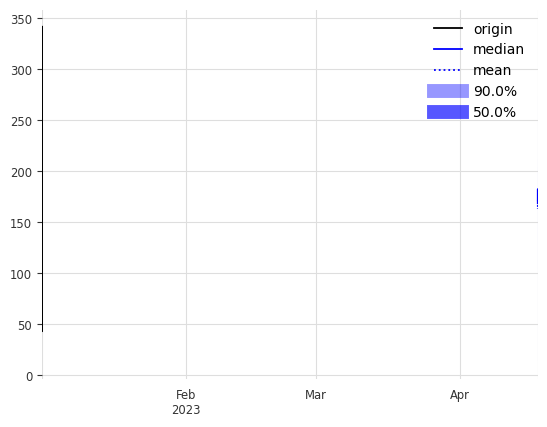

In [26]:
# series.plot()
target[begin:end + pred_len * pd.offsets.Minute()].plot(label="origin", legend=True)
for pred in preds:
    pred.plot(show_mean=True)
plt.legend()

In [27]:
from gluonts.dataset.split import split
train, test_template = split(data, offset=pred_len)
test_data = test_template.generate_instances(
    prediction_length=pred_len, windows=int(len(target)/pred_len),
)
print(len(test_data))

10


In [28]:
preds = predictor.predict(test_data.input)
preds = list(preds)
print(len(preds))

10


In [29]:
import numpy as np

def sample_df(forecast):
    samples = forecast.samples
    ns, h = samples.shape
    dates = pd.date_range(forecast.start_date.to_timestamp(), freq=forecast.freq, periods=h)
    return pd.DataFrame(samples.T, index=dates)

In [30]:
samples = [preds[0].samples]
start = preds[0].start_date
last_start = start
for pred in preds[1:]:
    samples.append(pred.samples)
    diff = pred.start_date - last_start
    if diff != pred_len * pd.offsets.Minute():
        raise ValueError()
    last_start = pred.start_date
samples = np.concatenate(samples, axis=1)

In [25]:
print(start)

2023-01-01 00:05


In [26]:
from gluonts.model.forecast import SampleForecast
aggr = SampleForecast(samples=samples, start_date=start)

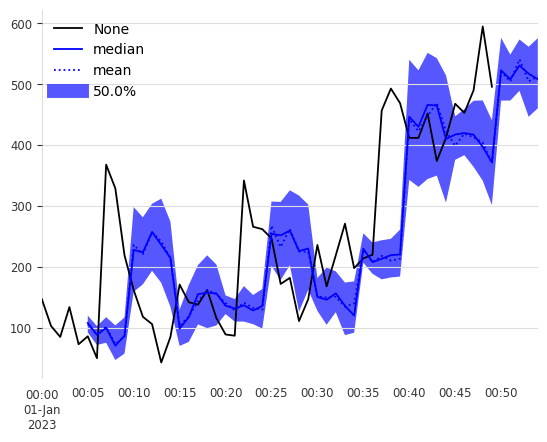

In [27]:
target.plot()
aggr.plot(show_mean=True, prediction_intervals=[50])
plt.legend()

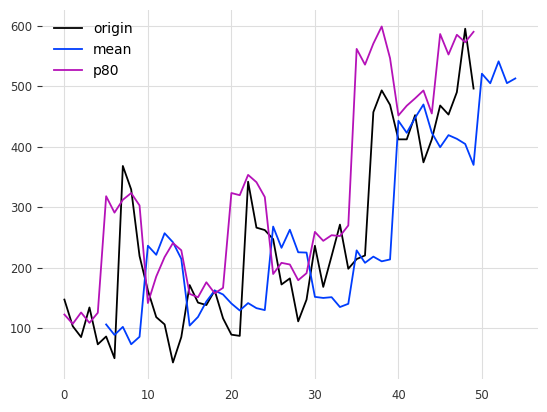

In [33]:
plt.plot(target.values, label="origin")
plt.plot(np.arange(len(aggr.mean)) + context_len, aggr.mean, label="mean")
# plt.plot(aggr.mean, label="mean")
plt.plot(aggr.quantile(0.8), label="p80")
# plt.plot(aggr.quantile(0.75), label="p75")
# plt.plot(aggr.quantile(0.7), label="p70")
plt.legend()

-72.15998840332031

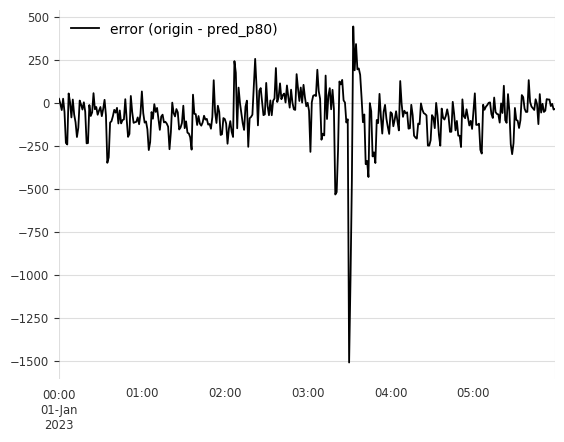

In [68]:
from functools import partial

aggr_df = sample_df(aggr)
# pred_name, pred_outs = "pred_mean", aggr_df.mean(axis=1)
# pred_name, pred_outs = "pred_p80", aggr_df.agg(partial(np.percentile, q=80), axis=1)
# pred_name, pred_outs = "pred_p70", aggr_df.agg(partial(np.percentile, q=70), axis=1)
# pred_name, pred_outs = "pred_p60", aggr_df.agg(partial(np.percentile, q=60), axis=1)
# pred_name, pred_outs = "pred_p50", aggr_df.agg(partial(np.percentile, q=50), axis=1)
# pred_name, pred_outs = "pred_p40", aggr.quantile(0.4)

# pred_outs = pd.Series(pred_outs.values, index=pred_outs.index.to_period(freq="min"))

# pred_outs = aggr.mean
# pred_outs = aggr.quantile(0.8)

err = target - pred_outs
err.plot(label=f"error (origin - {pred_name})", legend=True)
err.mean()

In [26]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(data, predictor, num_samples=10)
forecasts = list(forecast_it)
tss = list(ts_it)

In [27]:
import matplotlib.pyplot as plt

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 30
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()